# Выявление токсичных комментариев

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель для классификации комментиариев на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

*Примечание: Значение метрики F1 на тестовой выборке должно быть не меньше 0.75.*

**Описание данных**

Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

## Подготовка данных

In [ ]:
!pip install --upgrade scikit-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.9 MB/s eta 0:00:00


In [ ]:
import lightgbm as lgb
import nltk
import numpy as np
import pandas as pd
import re
import warnings

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from tqdm import notebook
from tqdm import tqdm

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data = pd.read_csv('/datasets/toxic_comments.csv')

data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Удалим столбец 'Unnamed: 0', поскольку он не несет в себе никакой важной информации.

In [ ]:
data = data.drop(columns='Unnamed: 0')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Датасет содержит 159292 комментария. Тип данных соответствует представленной информации.

Проверим наличие пропусков.

In [ ]:
data.isna().sum()

text     0
toxic    0
dtype: int64

Пропусков не обнаружено.   


Проверим наличие дубликатов.

In [ ]:
data.duplicated().sum()

0

Дубликатов не обнаружено.   

Для удобства приведем текст к нижнему регистру.

In [ ]:
data['text'] = data['text'].str.lower()

Напишем функцию для очистки и предварительной обработки данных.


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def text_preprocessing(text):
    # очистим текст
    text = re.sub(re.compile('<.*?>'), '', text)
    text =  re.sub('[^A-Za-z0-9]+', ' ', text)
    # переведем в токены
    tokens = nltk.word_tokenize(text)
    text = "".join(tokens)
    # удалим стоп-слова
    text = [word for word in tokens if word not in stop_words]
    # лемматизируем текст
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [ ]:
tqdm.pandas()
data['text'] = data['text'].progress_apply(text_preprocessing)

100%|██████████| 159292/159292 [02:12<00:00, 1198.28it/s]


Исследуем баланс классов.

0    0.898388
1    0.101612
Name: toxic, dtype: float64


<Axes: >

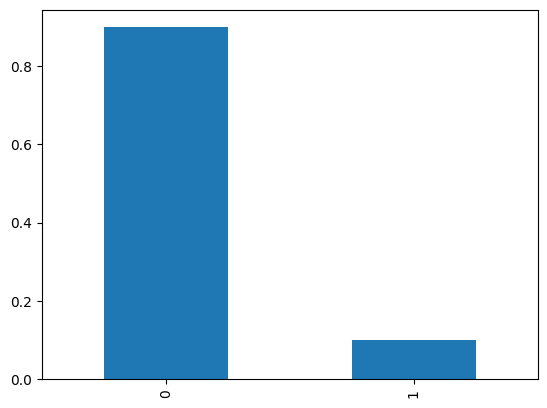

In [ ]:
class_frequency = data['toxic'].value_counts(normalize = 1)
print(class_frequency)
class_frequency.plot(kind='bar')

Разделим датасет на тренировочную и тестовую выборки. Используем параметр stratify, чтобы иметь равные пропорции классов в train и test.

In [ ]:
features = data['text']
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

len(features_train), len(features_test), len(target_train), len(target_test)

(127433, 31859, 127433, 31859)

Преобразуем слова в векторы при помощи TfidfVectorizer.

In [ ]:
vectorizer = TfidfVectorizer()

features_train_vect = vectorizer.fit_transform(features_train)
features_test_vect = vectorizer.transform(features_test)

**Вывод**     
В процессе подготовки данных был удален столбец 'Unnamed: 0', так как он не имеет ценности для решения задачи.         
Текст был очищен, удалены стоп-слова. Была проведена лемматизация при помощи WordNetLemmatizer. После чего полученные леммы были преобразованы в векторы при помощи TfidfVectorizer.


## Обучение

Обучим модель LogisticRegression. Для подбора гиперпараметров воспользуемся GridSearchCV.

In [ ]:
%%time
parameters = {'C': np.linspace(10, 20, num = 11, endpoint = True),
             'max_iter': [1000]}
lr = LogisticRegression(random_state = 12345)
model_lr = GridSearchCV(lr, parameters, cv=5, scoring='f1', n_jobs=-1, verbose=2)
model_lr.fit(features_train_vect, target_train)
model_lr.best_score_

Fitting 5 folds for each of 11 candidates, totalling 55 fits
CPU times: user 33.8 s, sys: 31.9 s, total: 1min 5s
Wall time: 12min 9s


0.7680013005289759

Обучим модель LinearSVC. Подберем параметры при помощи RandomizedSearchCV.

In [ ]:
%%time
parameters = {'C': np.logspace(-3, 3, 7, 9),
               'loss': ['hinge', 'squared_hinge']}
svc = LinearSVC()
model_svc = RandomizedSearchCV(svc, param_distributions=parameters, cv=5,
                   verbose=True, scoring='f1', random_state=12345)
model_svc.fit(features_train_vect, target_train)
model_svc.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 6min 1s, sys: 1.89 s, total: 6min 2s
Wall time: 6min 3s


0.7724855348488525

Обучим модель DecisionTreeClassifier. Подберем параметры при помощи RandomizedSearchCV.

In [ ]:
%%time
parameters = {'max_depth': [depth for depth in range(1, 20)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}
dt =  DecisionTreeClassifier()
model_dt = RandomizedSearchCV(dt, param_distributions=parameters, cv=5,
                   verbose=True, scoring='f1', random_state=12345)
model_dt.fit(features_train_vect, target_train)
model_dt.best_score_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 25min 41s, sys: 3.13 s, total: 25min 45s
Wall time: 25min 46s


0.6488268133825514

Обучим модель LightGBM. Подберем параметры при помощи RandomizedSearchCV.

In [ ]:
%%time
param_dist = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 300],
    'max_depth': [5, 10, 20],
    'min_data_in_leaf': [10, 30]
}
lgbc = lgb.LGBMClassifier()
model_lgbc = RandomizedSearchCV(lgbc, param_distributions=param_dist, n_iter=10,
                                scoring='f1', n_jobs = -1, cv=5, random_state=12345)
model_lgbc.fit(features_train_vect, target_train)
model_lgbc.best_score_

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 12949, number of negative: 114484
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 26.858734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 604976
[LightGBM] [Info] Number of data points in the train set: 127433, number of used features: 9009
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101614 -> in

0.6976843871413613

Проверим модель LinearSVC на тестовой выборке.

In [ ]:
predictions_test = model_svc.predict(features_test_vect)
print(f1_score(target_test, predictions_test))

0.787197820905686


Проверим модель на адекватность при помощи DummyClassifier.

In [ ]:
dummy_model = DummyClassifier(strategy='uniform')
dummy_model.fit(features_train_vect, target_train)
predictions_dummy = dummy_model.predict(features_test_vect)
print(f1_score(target_test, predictions_dummy))

0.16479983405932377


Результат на тестовой выборке значительно лучше результата, полученного на dummy-модели.

## Выводы

Перед нами стояла задача классифицикации комментариев на позитивные и негативные. Для этого были обучены 4 модели: LogisticRegression, LinearSVC, DecisionTreeClassifier и LGBMClassifier. Лучшее значение метрики F1 показала модель LinearSVC, она и была проверена на тестовой выборке. Результат F1 превысил пороговое значение в 0.75.